## Vehicle Detection

The goals / steps of this project are the following:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import os
import glob
import time
import math

from IPython.display import HTML
from PIL import Image
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
import cv2
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
color_space = 'HLS'
spatial_size = (8, 8)
hist_bins = 12
orient = 8
pix_per_cell = 12
cell_per_block = 2
hog_channel = "ALL"
spatial_feat = True
hist_feat = True
hog_feat = True

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [5]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256), hist_vec=True):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]+bin_edges[0:len(bin_edges)-1])/2
    # Return the individual histograms, bin_centers and feature vector
    if hist_vec == False:
        # Return the individual channel histograms, bin_centers and feature vector    
        return channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features
    else:
        # only return feature vector
        return hist_features
    return hist_features

In [6]:
def extract_features_from_image(image,cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    img_copy = np.copy(image)
    img_copy = np.uint8(img_copy*255)# convert to 255

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img_copy, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img_copy, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img_copy, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img_copy, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img_copy, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img_copy)      

    spatial_features_hls = []
    spatial_features_rgb = []
    hist_features_hls = []
    hist_features_rgb = []
    hog_features = []
    if spatial_feat == True:
        spatial_features_hls = bin_spatial(feature_image, size=spatial_size)
        spatial_features_rgb = bin_spatial(img_copy, size=spatial_size)
        features.append(spatial_features_hls)
        features.append(spatial_features_rgb)
    if hist_feat == True:
        # Apply color_hist()
        hist_features_hls = color_hist(feature_image, nbins=hist_bins)
        hist_features_rgb = color_hist(img_copy, nbins=hist_bins)
        features.append(hist_features_hls)
        features.append(hist_features_rgb)
    if hog_feat == True:
        # convert to gray scale
        feature_image_gray = cv2.cvtColor(img_copy, cv2.COLOR_RGB2GRAY) 
        hog_features = get_hog_features(feature_image_gray, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    #print("Extract features size = ",len(features))
    features_all = np.concatenate((spatial_features_hls,spatial_features_rgb,
                               hist_features_hls,hist_features_rgb,
                               hog_features))

    return features_all

In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features_all = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        image_rgb = np.uint8(image*255)# convert to 255
        features = extract_features_from_image(image_rgb, cspace=cspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        features_all.append(features)
        
    # Return list of feature vectors
    print("features_all dimensions = ",len(features_all)," each type is = ",len(features_all[0]))
    return features_all

In [8]:
##DATA EXPLORATION
##Load all the images
cars = []
notcars = []
cars = glob.glob ('vehicles/*/*.png',recursive=True)
notcars = glob.glob  ('non-vehicles/*/*.png',recursive=True)

In [9]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


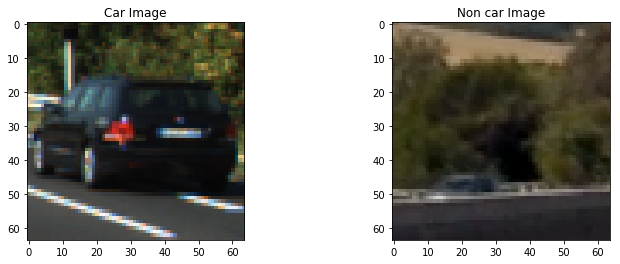

In [10]:
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Non car Image')
plt.savefig("output_images/CarAndNotCar.jpg")

Spatial features size: (192,)


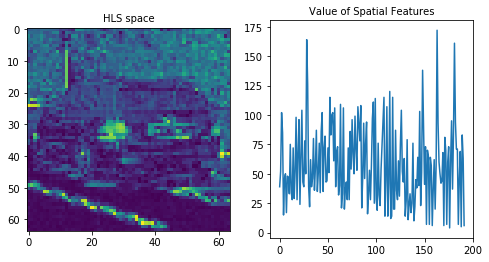

In [11]:
car_image_rgb = np.uint8(car_image*255)# convert to 255

# Extract spatial features, work on the saturation channel
car_image_hls = cv2.cvtColor(car_image_rgb,cv2.COLOR_RGB2HLS)
spatial_s = bin_spatial(car_image_hls, size=spatial_size)

print('Spatial features size:', spatial_s.shape)

# Visualize
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.imshow(car_image_hls[:,:,2])
ax1.set_title('HLS space', fontsize=10)
ax2.plot(spatial_s)
ax2.set_title('Value of Spatial Features', fontsize=10)
plt.savefig("output_images/SpatialFeatures.jpg")

color hist features size: (36,)


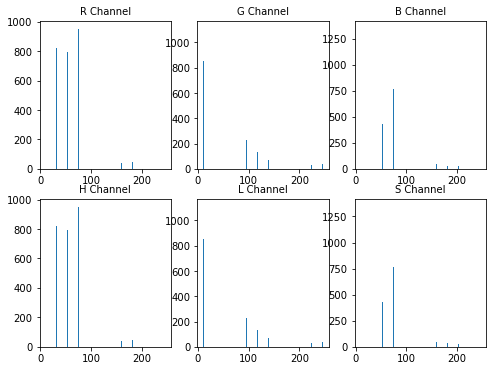

In [12]:
# RGB color space
rh, gh, bh, bincen, hist_rgb = color_hist(car_image_rgb, nbins=hist_bins,hist_vec=False)
# HLS color space
hh, lh, sh, bincen, hist_hls = color_hist(car_image_rgb, nbins=hist_bins,hist_vec=False)

print('color hist features size:', hist_rgb.shape)

# Visualize histogram
f, ((ax1, ax2,ax3),(ax4, ax5,ax6) )= plt.subplots(2, 3, figsize=(8,6))
# R Channel
ax1.bar(bincen, rh[0])
ax1.set_title('R Channel', fontsize=10)
# G Channel
ax2.bar(bincen, gh[0])
ax2.set_title('G Channel', fontsize=10)
# B Channel
ax3.bar(bincen, bh[0])
ax3.set_title('B Channel', fontsize=10)

# H Channel
ax4.bar(bincen, hh[0])
ax4.set_title('H Channel', fontsize=10)
# L Channel
ax5.bar(bincen, lh[0])
ax5.set_title('L Channel', fontsize=10)
# S Channel
ax6.bar(bincen, sh[0])
ax6.set_title('S Channel', fontsize=10)
plt.savefig("output_images/ColorHistogramFeatures.jpg")

Hog features shape: (7, 7, 2, 2, 8)
Flatterned Hog features size: (1568,)


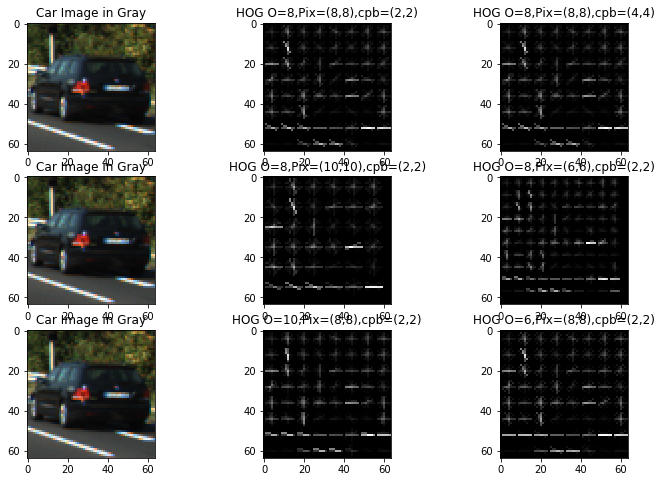

In [13]:
# work on grey scale image
car_image_gray = cv2.cvtColor(car_image_rgb, cv2.COLOR_RGB2GRAY) # convert to gray scale

# Call our function with vis=True to see an image output, 
# feature_vec=False to get the feature dimension
hog_features_1, hog_image_1 = get_hog_features(car_image_gray, orient=8,pix_per_cell=8, cell_per_block=2,vis=True, feature_vec=False)
hog_features_2, hog_image_2 = get_hog_features(car_image_gray, orient=8,pix_per_cell=8, cell_per_block=4,vis=True, feature_vec=False)
hog_features_3, hog_image_3 = get_hog_features(car_image_gray, orient=8,pix_per_cell=10, cell_per_block=2,vis=True, feature_vec=False)
hog_features_4, hog_image_4 = get_hog_features(car_image_gray, orient=8,pix_per_cell=6, cell_per_block=2,vis=True, feature_vec=False)
hog_features_5, hog_image_5 = get_hog_features(car_image_gray, orient=10,pix_per_cell=8, cell_per_block=2,vis=True, feature_vec=False)
hog_features_6, hog_image_6 = get_hog_features(car_image_gray, orient=6,pix_per_cell=8, cell_per_block=2,vis=True, feature_vec=False)
# flattern the feature to create the feature vector
hog_1d = np.ravel(hog_features_1) 

# Plot the examples
fig = plt.figure(figsize=(12,8))
plt.subplot(331)
plt.imshow(car_image_rgb)
plt.title('Car Image in Gray')
plt.subplot(332)
plt.imshow(hog_image_1, cmap='gray')
plt.title('HOG O=8,Pix=(8,8),cpb=(2,2)')
plt.subplot(333)
plt.imshow(hog_image_2, cmap='gray')
plt.title('HOG O=8,Pix=(8,8),cpb=(4,4)')

plt.subplot(334)
plt.imshow(car_image_rgb)
plt.title('Car Image in Gray')
plt.subplot(335)
plt.imshow(hog_image_3, cmap='gray')
plt.title('HOG O=8,Pix=(10,10),cpb=(2,2)')
plt.subplot(336)
plt.imshow(hog_image_4, cmap='gray')
plt.title('HOG O=8,Pix=(6,6),cpb=(2,2)')

plt.subplot(337)
plt.imshow(car_image_rgb)
plt.title('Car Image in Gray')
plt.subplot(338)
plt.imshow(hog_image_5, cmap='gray')
plt.title('HOG O=10,Pix=(8,8),cpb=(2,2)')
plt.subplot(339)
plt.imshow(hog_image_6, cmap='gray')
plt.title('HOG O=6,Pix=(8,8),cpb=(2,2)')


plt.savefig("output_images/HogFeaturesWithGray.jpg")

# test the funtion
print('Hog features shape:', hog_features_1.shape)
print('Flatterned Hog features size:', hog_1d.shape)

Hog features shape: (7, 7, 2, 2, 8)
Flatterned Hog features size: (1568,)


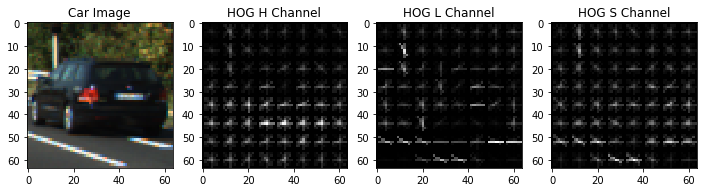

In [14]:
# work on grey scale image
car_image_hls = cv2.cvtColor(car_image_rgb, cv2.COLOR_RGB2HLS) # convert to gray scale

# Call our function with vis=True to see an image output, 
# feature_vec=False to get the feature dimension
hog_features_h, hog_image_h = get_hog_features(car_image_hls[:,:,0], 8,8, 2,vis=True, feature_vec=False)

# flattern the feature to create the feature vector
hog_1d_h = np.ravel(hog_features_h) 

# Call our function with vis=True to see an image output, 
# feature_vec=False to get the feature dimension
hog_features_l, hog_image_l = get_hog_features(car_image_hls[:,:,1], 8,8, 2,vis=True, feature_vec=False)

# flattern the feature to create the feature vector
hog_1d_l = np.ravel(hog_features_l) 

# Call our function with vis=True to see an image output, 
# feature_vec=False to get the feature dimension
hog_features_s, hog_image_s = get_hog_features(car_image_hls[:,:,2], 8,8, 2,vis=True, feature_vec=False)

# flattern the feature to create the feature vector
hog_1d_s = np.ravel(hog_features_s) 

# Plot the examples
fig = plt.figure(figsize=(12,4))
plt.subplot(141)
plt.imshow(car_image_rgb)
plt.title('Car Image')
plt.subplot(142)
plt.imshow(hog_image_h, cmap='gray')
plt.title('HOG H Channel')
plt.subplot(143)
plt.imshow(hog_image_l, cmap='gray')
plt.title('HOG L Channel')
plt.subplot(144)
plt.imshow(hog_image_s, cmap='gray')
plt.title('HOG S Channel')
plt.savefig("output_images/HogFeaturesWithHLS.jpg")

# test the funtion
print('Hog features shape:', hog_features_l.shape)
print('Flatterned Hog features size:', hog_1d_l.shape)

Hog features shape: (7, 7, 2, 2, 8)
Flatterned Hog features size: (1568,)


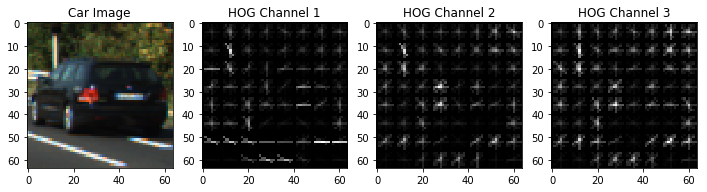

In [15]:
# work on grey scale image
car_image_YCrCb = cv2.cvtColor(car_image_rgb, cv2.COLOR_RGB2YCrCb) # convert to gray scale

# Call our function with vis=True to see an image output, 
# feature_vec=False to get the feature dimension
hog_features_1, hog_image_1 = get_hog_features(car_image_YCrCb[:,:,0], 8,8, 2,vis=True, feature_vec=False)
hog_features_2, hog_image_2 = get_hog_features(car_image_YCrCb[:,:,1], 8,8, 2,vis=True, feature_vec=False)
hog_features_3, hog_image_3 = get_hog_features(car_image_YCrCb[:,:,2], 8,8, 2,vis=True, feature_vec=False)

# flattern the feature to create the feature vector
hog_1d_1 = np.ravel(hog_features_1) 

# Plot the examples
fig = plt.figure(figsize=(12,4))
plt.subplot(141)
plt.imshow(car_image_rgb)
plt.title('Car Image')
plt.subplot(142)
plt.imshow(hog_image_1, cmap='gray')
plt.title('HOG Channel 1')
plt.subplot(143)
plt.imshow(hog_image_2, cmap='gray')
plt.title('HOG Channel 2')
plt.subplot(144)
plt.imshow(hog_image_3, cmap='gray')
plt.title('HOG Channel 3')
plt.savefig("output_images/HogFeaturesWithYCrCb.jpg")

# test the funtion
print('Hog features shape:', hog_features_1.shape)
print('Flatterned Hog features size:', hog_1d_1.shape)

**Starting HOG**
features_all dimensions =  8792  each type is =  968
features_all dimensions =  8968  each type is =  968
**DONE HOG**
41.67 Seconds to extract HOG features...
Using: 8 orientations 12 pixels per cell and 2 cells per block
Feature vector length: 968


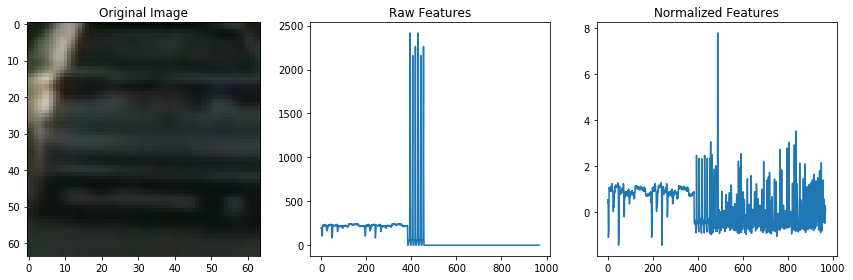

In [16]:
car_features = []
notcar_features = []
i = 0
print('**Starting HOG**')

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

t=time.time()
car_features = extract_features(cars, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
print('**DONE HOG**')

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# plot feature normalization
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()
plt.savefig("output_images/RawAndNormalizedFeatures.jpg")

#Shuffle the training dataset
# shuffle the training set
shuffled_X, shuffled_y = shuffle( scaled_X, y, random_state=42)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
# X_train, X_test, y_train, y_test = train_test_split(
#     scaled_X, y, test_size=0.2, random_state=rand_state)
X_train, X_test, y_train, y_test = train_test_split(
    shuffled_X, shuffled_y, test_size=0.2, random_state=rand_state)
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


In [17]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

4.5 Seconds to train SVC...
Test Accuracy of SVC =  0.9623
My SVC predicts:  [ 0.  0.  1.  0.  0.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  1.  0.  0.  0.  0.]
0.0023 Seconds to predict 10 labels with SVC


In [18]:
# Tuning Classifier Parameters

# max_feature
x = [3,4,6] 
# max_depth 
y = [4,8,25]
# tree leaf
z = [2,4]

# grid search
for i in x:
    for j in y:
        for k in z:
            print ("feature: {} ,depth: {} ,leaf: {}".format(i,j,k ))
            clf = RandomForestClassifier(n_estimators = 100,
                                         max_features = i,
                                         max_depth = j,
                                         min_samples_leaf = k,
                                         random_state = 42,) 
            # fit the classifier
            clf.fit(X_train, y_train)
            # predict
            pred = clf.predict_proba(X_test)[:,1]
            # compute auroc score
            auroc = roc_auc_score(y_test, pred)
            print('auroc = ', round(auroc, 4))

feature: 3 ,depth: 4 ,leaf: 2
auroc =  0.9679
feature: 3 ,depth: 4 ,leaf: 4
auroc =  0.9678
feature: 3 ,depth: 8 ,leaf: 2
auroc =  0.9915
feature: 3 ,depth: 8 ,leaf: 4
auroc =  0.9913
feature: 3 ,depth: 25 ,leaf: 2
auroc =  0.9968
feature: 3 ,depth: 25 ,leaf: 4
auroc =  0.9962
feature: 4 ,depth: 4 ,leaf: 2
auroc =  0.9687
feature: 4 ,depth: 4 ,leaf: 4
auroc =  0.9688
feature: 4 ,depth: 8 ,leaf: 2
auroc =  0.9923
feature: 4 ,depth: 8 ,leaf: 4
auroc =  0.9921
feature: 4 ,depth: 25 ,leaf: 2
auroc =  0.9972
feature: 4 ,depth: 25 ,leaf: 4
auroc =  0.9966
feature: 6 ,depth: 4 ,leaf: 2
auroc =  0.9733
feature: 6 ,depth: 4 ,leaf: 4
auroc =  0.9733
feature: 6 ,depth: 8 ,leaf: 2
auroc =  0.994
feature: 6 ,depth: 8 ,leaf: 4
auroc =  0.994
feature: 6 ,depth: 25 ,leaf: 2
auroc =  0.9975
feature: 6 ,depth: 25 ,leaf: 4
auroc =  0.9972


In [19]:
# the best parameters
clf = RandomForestClassifier(n_estimators=100, max_features = 2,
                             min_samples_leaf = 4,max_depth = 25)

# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train ...')

# test on training set
pred = clf.predict_proba(X_train)[:,1] # probability
pred_bi =  clf.predict(X_train) # binary class
auroc = roc_auc_score(y_train, pred)# auroc 
accuracy  = accuracy_score(y_train, pred_bi) # accuracy
print('Training auroc    =', round(auroc, 4))
print('Training accuracy =', round(accuracy, 4))


# test on validation set
pred = clf.predict_proba(X_test)[:,1] # probability
pred_bi =  clf.predict(X_test) # binary class
auroc = roc_auc_score(y_test, pred) # auroc 
accuracy  = accuracy_score(y_test, pred_bi) # accuracy
print('Testing auroc    =', round(auroc, 4))
print('Testing accuracy =', round(accuracy, 4))

2.46 Seconds to train ...
Training auroc    = 1.0
Training accuracy = 0.9977
Testing auroc    = 0.9962
Testing accuracy = 0.9755


In [20]:
X_all = np.concatenate((X_train,X_test))
y_all = np.concatenate((y_train,y_test))
# shuffle the data set
X_all, y_all = shuffle( X_all, y_all, random_state=42) 
clf.fit(X_all, y_all)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=2, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [21]:
# print data size
print('Scaled data set:', scaled_X.shape)
print('Training set    :', X_train.shape)
print('Test set    :', X_test.shape)
print('Training set    :', y_train.shape)
print('Test set    :', y_test.shape)
print('X_all    :', X_all.shape)
print('y_all    :', y_all.shape)


Scaled data set: (17760, 968)
Training set    : (14208, 968)
Test set    : (3552, 968)
Training set    : (14208,)
Test set    : (3552,)
X_all    : (17760, 968)
y_all    : (17760,)


In [22]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [23]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [24]:
image = mpimg.imread('test_images/test4.jpg')
# image_file = []
# image_file.append('test_images/test4.jpg')

# define the minimum window size
x_min =[800, 1280]
y_min =[400, 530]
xy_min = (80, 80)

# define the maxium window size
x_max =[800, 1280]
y_max =[400, 590]
xy_max = (160, 160)

# intermedian windows
n = 6 # the number of total window sizes
x = []
y = []
xy =[]
# chose the intermediate sizes by interpolation.
for i in range(n):
    x_start_stop =[int(x_min[0] + i*(x_max[0]-x_min[0])/(n-1)), 
                   int(x_min[1] + i*(x_max[1]-x_min[1])/(n-1))]
    y_start_stop =[int(y_min[0] + i*(y_max[0]-y_min[0])/(n-1)), 
                   int(y_min[1] + i*(y_max[1]-y_min[1])/(n-1))]
    xy_window    =[int(xy_min[0] + i*(xy_max[0]-xy_min[0])/(n-1)), 
                   int(xy_min[1] + i*(xy_max[1]-xy_min[1])/(n-1))]
    x.append(x_start_stop)
    y.append(y_start_stop)
    xy.append(xy_window)
print("Sizes of all windows..")
print(x, " : ", y, " : ", xy)

Sizes of all windows..
[[800, 1280], [800, 1280], [800, 1280], [800, 1280], [800, 1280], [800, 1280]]  :  [[400, 530], [400, 542], [400, 554], [400, 566], [400, 578], [400, 590]]  :  [[80, 80], [96, 96], [112, 112], [128, 128], [144, 144], [160, 160]]


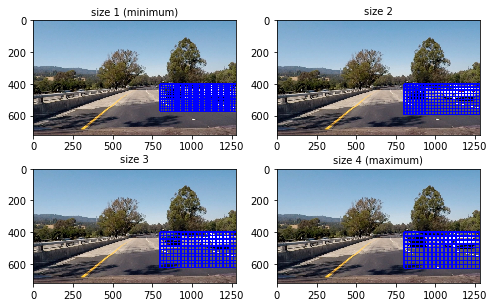

In [25]:
# visualize different window size
windows1 = slide_window(image, x_start_stop= x[0], y_start_stop = y[0], 
                    xy_window= xy[0], xy_overlap=(0.80, 0.80))
windows2 = slide_window(image, x_start_stop= x[1], y_start_stop = y[1], 
                    xy_window= xy[1], xy_overlap=(0.80, 0.80))
windows3 = slide_window(image, x_start_stop= x[2], y_start_stop = y[2], 
                    xy_window= xy[2], xy_overlap=(0.80, 0.80))
windows4 = slide_window(image, x_start_stop= x[3], y_start_stop = y[3], 
                    xy_window= xy[3], xy_overlap=(0.80, 0.80))


window_img1 = draw_boxes(image, windows1, color=(0, 0, 255), thick=6)
window_img2 = draw_boxes(image, windows2, color=(0, 0, 255), thick=6)                    
window_img3 = draw_boxes(image, windows3, color=(0, 0, 255), thick=6)
window_img4 = draw_boxes(image, windows4, color=(0, 0, 255), thick=6)


f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(8,5))
ax1.imshow(window_img1)
ax1.set_title('size 1 (minimum)', fontsize=10)
ax2.imshow(window_img2)
ax2.set_title('size 2', fontsize=10)
ax3.imshow(window_img3)
ax3.set_title('size 3', fontsize=10)
ax4.imshow(window_img4)
ax4.set_title('size 4 (maximum)', fontsize=10)
plt.savefig("output_images/AllSizedWindows.jpg")

In [26]:
# combine all windows
windows_all = list(windows1 + windows2 + windows3 + windows4)
print('Total number of windows:',len(windows_all))

Total number of windows: 571


In [27]:
# preprocess the image by crop the window, and resize
def crop_image_and_resize(img,window):
    # crop the image
    img_crop = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    # resize the image to 64 by 64
    img_resized = cv2.resize(img_crop, (64, 64))
    return img_resized

In [28]:
# extract features from a test image
def features_from_img(img):
    # Create a list to append feature vectors to
    features_all = []
    
    for n in range(len(windows_all)):
        # Read in each one by one
        image_rgb = crop_image_and_resize(img,windows_all[n])
        # extract features
        #features = extract_features_from_image(image_rgb,cspace='HLS',hog_channel=hog_channel)
        features = extract_features_from_image(image_rgb, cspace=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        # append features
        features_all.append(features)
    # scale
    scaled_features = X_scaler.transform(features_all)
    # Return list of feature vectors
    return scaled_features

In [30]:
# Test the funcion
img_features = features_from_img(image)
# prediction
pred = clf.predict_proba(img_features)[:,1] # svc.predict(img_features)
print('The first 10 prediction results', pred[0:10])

The first 10 prediction results [ 0.39047294  0.55437392  0.55770133  0.57779365  0.50764585  0.48175549
  0.41423046  0.40053871  0.33174917  0.31546756]


In [31]:
# return windows with car images
def get_car_windows(pred):
    windows_car = []
    for n in range(len(pred)):
        if pred[n] > 0.51: # increase the threshold will miss more True Positive 
                                # the classifier have a narrow margin
            windows_car.append(windows_all[n])
    return windows_car

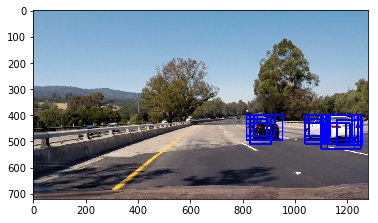

In [32]:
# return the results
windows_car = get_car_windows(pred)

# plot the windows put on the images
img_box = draw_boxes(image, windows_car, color=(0, 0, 255), thick=6)
plt.imshow(img_box)

In [33]:
# define a function to find boxes with cars
def find_cars(img):
    # extract feature
    img_features = features_from_img(img)
    
    # prediction
    pred = clf.predict_proba(img_features)[:,1]
    #pred = svc.predict(img_features)
    # get windows with car images
    windows_car = get_car_windows(pred)
    
    return windows_car

axes =  6
test_images =  6


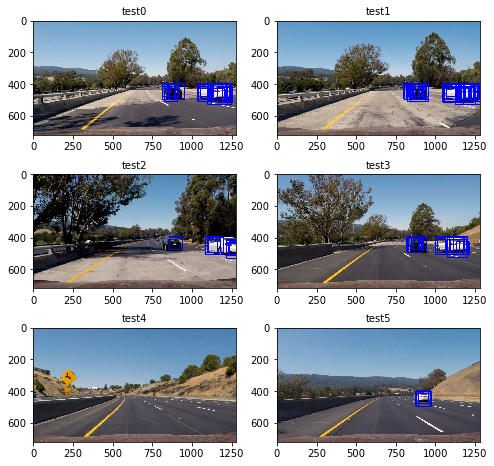

In [34]:
test_images = glob.glob ('test_images/*.jpg')

f, ((ax1, ax2),(ax3, ax4),(ax5, ax6))= plt.subplots(3, 2, figsize=(8,8))
axes = [ax1,ax2,ax3,ax4,ax5,ax6]

idx = 0
for t_img in test_images:
    temp_image = mpimg.imread(t_img)
    windows_car = find_cars(temp_image)
    axes[idx].imshow(draw_boxes(temp_image, windows_car, color=(0, 0, 255), thick=6))
    title = 'test'+str(idx)
    axes[idx].set_title(title, fontsize=10)
    idx = idx + 1
print("axes = ",len(axes))
print("test_images = ",len(test_images))
# print("window_cars = ",len(window_cars))
plt.savefig("output_images/DrawBoxAllTestImages.jpg")

In [35]:
# create a heat map
def add_heat(heatmap, boxlist):
    # Iterate through list of bboxes    
    for box in boxlist:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap

In [36]:
# truncate value exeed upper limit
def apply_upper_threshold(heatmap, upper):
    # Zero out pixels below the threshold
    heatmap[heatmap > upper] = 1
    # Return thresholded map
    return heatmap

In [37]:
# get value below lower limit to 0
def apply_lower_threshold(heatmap, lower):
    # Zero out pixels below the threshold
    heatmap[heatmap < lower] = 0
    # Return thresholded map
    return heatmap

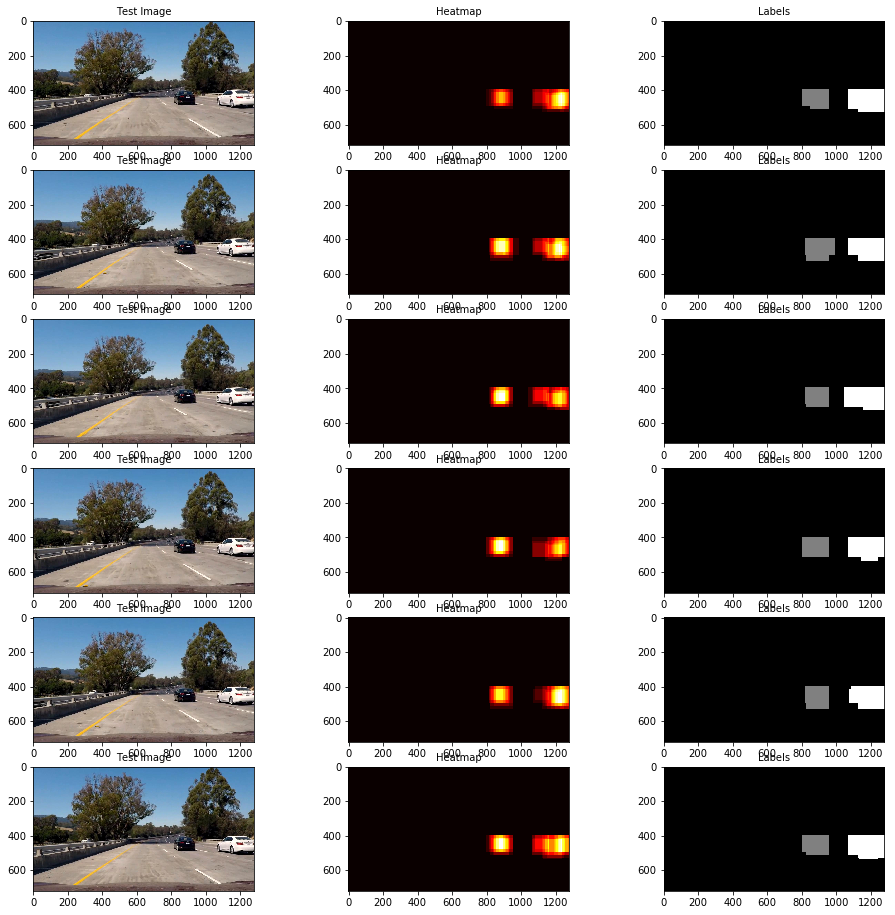

In [40]:
test_images = glob.glob ('six_live_frames/*.jpg')

f, ((ax1,ax2, ax3),(ax4,ax5, ax6),(ax7,ax8, ax9),(ax10,ax11,ax12),(ax13,ax14,ax15),(ax16,ax17,ax18))= plt.subplots(6, 3, figsize=(16,16))
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18]

heatmap_integrated = np.zeros_like(image[:,:,0]).astype(np.float)
idx = 0
for t_img in test_images:
    temp_image = mpimg.imread(t_img)
    bboxes = find_cars(temp_image)

    # initialize heat map
    heat = np.zeros_like(temp_image[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, bboxes)
    heatmap_integrated = heatmap_integrated + heatmap
    labels = label(heatmap)

    #print(labels[1], 'cars found')
    axes[idx].imshow(temp_image)
    axes[idx].set_title('Test Image', fontsize=10)
    idx = idx + 1
    
    axes[idx].imshow(heatmap, cmap='hot')
    axes[idx].set_title('Heatmap', fontsize=10)
    idx = idx + 1
    
    axes[idx].imshow(labels[0], cmap='gray')
    axes[idx].set_title('Labels', fontsize=10)
    idx = idx + 1
plt.savefig("output_images/HeatmapAndLabelAllTestImages.jpg")

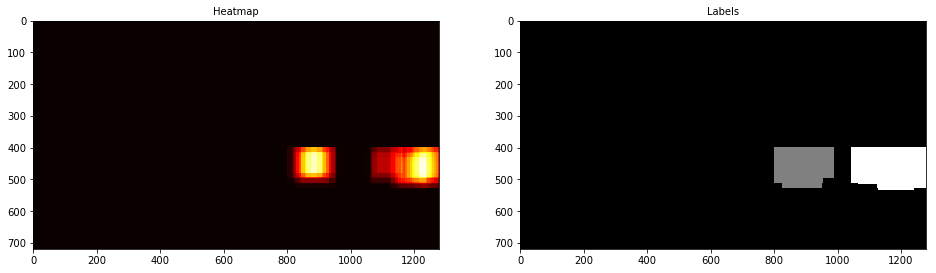

In [41]:
labels = label(heatmap_integrated)
f, ((ax1,ax2))= plt.subplots(1, 2, figsize=(16,16))
ax1.imshow(heatmap_integrated, cmap='hot')
ax1.set_title('Heatmap', fontsize=10)

ax2.imshow(labels[0], cmap='gray')
ax2.set_title('Labels', fontsize=10)

plt.savefig("output_images/IntegratedHeatmapAndLabel.jpg")

In [42]:
# define a function to find bounding box of the labels
def find_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    draw_img = np.copy(img)
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # append the bounding box to a list
        bboxes.append(bbox)
    # Return the bounding boxes
    return bboxes

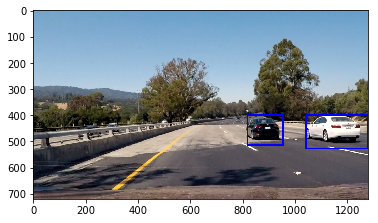

In [43]:
# test the funciton 
# find car images
boxes = find_cars(mpimg.imread('six_live_frames/frame6.jpg'))
# inicalize a heat map
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# increase heatmap value on car images
heatmap = add_heat(heat, boxes)
# apply threshod
heatmap = apply_lower_threshold(heatmap, 1)
# find labels
labels = label(heatmap)
# find bounding boxes
bboxes = find_labeled_bboxes(image, labels)
# draw bounding boxes
img_box = draw_boxes(image, bboxes, color=(0, 0, 255), thick=6)
plt.imshow(img_box)
plt.savefig("output_images/BoundingBoxOnLastFrame.jpg")

In [44]:
# define a car object
class car():
        def __init__(self):
            self.average_centroid= (0,0) # average centroid
            self.width = 0 # average box width
            self.height = 0 # average height
            self.detected = 0.5  # moving average

In [45]:
# define a function to find nearby car object 
def track_car(cntrd,old_Cars):
    threshold_dist = 40 # the maxium distance to consider nearby
    Dist = [] # a list of distance
    if not old_Cars: # if the list of nearby cars is empty
        # return car not found 
        car_found = False 
        car_id = 0
        return car_found,car_id
    else:
        for car in old_Cars:
            # Find distance between centroid and car's average centroid
            Dist.append(np.sqrt((cntrd[0]-car.average_centroid[0])**2 + (cntrd[1]-car.average_centroid[1])**2))
        car_id = np.argmin(Dist)
        if Dist[car_id] < threshold_dist:
            car_found = True
        else:
            car_found = False
        return car_found, car_id

In [46]:
# find the centroid and size of a bounding box
def find_box_centroid_size(bboxes):
    box_centroids = []
    box_size = []
    
    for box in bboxes:
        x = int((box[0][0] + box[1][0])/2)
        y = int((box[0][1] + box[1][1])/2)
        box_centroids.append((x,y))

        width =  int((box[1][0] - box[0][0])/2)
        height = int((box[1][1] - box[0][1])/2)
        width =  int(box[1][0] - box[0][0])
        height = int(box[1][1] - box[0][1])
        box_size.append((width,height))
    return box_centroids, box_size

In [47]:
# define bounding boxes of detacted cars
def find_car_box(Old_Cars, detected_threshold = 0.51):
    box2 = []
    for car2 in Old_Cars:
        if car2.detected > detected_threshold:
            offset = car2.average_centroid          
            width = car2.width*1/2
            height = car2.height*1/2
            bbox0 = (int(-width+offset[0]),
                     int(-height+offset[1]))
            bbox1 = (int(width+offset[0]),
                     int(height+offset[1]))
            box2.append((bbox0,bbox1))
    return box2

In [48]:
# video pipeline
def process_img(image):
    # define car object
    class car():
        def __init__(self):
            self.average_centroid= (0,0) # average centroid
            self.width = 0 # average box width
            self.height = 0 # average height
            self.detected = 0.5  # moving average
    
    global Detected_Cars
    global heatmap
    
    # make a copy of the incial image
    draw_img = np.copy(image)
    
    # find windows that contains cars
    boxes = find_cars(image)
    
    # draw windows that contains cars
    draw_img = draw_boxes(draw_img, boxes, color=(0, 0, 255), thick=2)


    # create a new heat map
    heatmap_new = np.zeros_like(image[:,:,0]).astype(np.float)
    # increase heatmap value on windows contain cars
    heatmap_new = add_heat(heatmap_new, boxes)
    # truncate the value if it's greater than 1. 
    # It's easy to set the threshold value for the 
    # moving average funciton, if the values are bounded
    heatmap_new = apply_upper_threshold(heatmap_new,1)
    
    # update the heatmap with the moving average algorithm 
    # so that, if car image are no longer detected, that area "cool" down
    heatmap = 0.9*heatmap + 0.1*heatmap_new
        
    
    # wrap heatmap to the orignal image
    wrap_img = np.zeros_like(image) # inicalize
    wrap_img[:,:,1] = heatmap[:]*250 # adding heat map
    # blend image with the heat map
    draw_img = cv2.addWeighted(draw_img, 1, wrap_img, 0.5, 0)

    # create a new heatmap to show the heatmap with more certainty 
    # by thresholding the heatmap value
    heatmap_sure = np.copy(heatmap)
    # get area of higher certainty by thredholding the heatmap
    heatmap_sure = apply_lower_threshold(heatmap_sure, 0.97)
    #labels of areas
    labels = label(heatmap_sure)
    # finding the bounding box of labeled area
    bounding_boxes = find_labeled_bboxes(image, labels)
    
     
    # find centroy and size of bounding box
    centroids,box_size = find_box_centroid_size(bounding_boxes)
    

    New_Cars = [] # initialize a list of new found cars
    for n in range(len(centroids)):
        # find nearby car object          
        car_found, k = track_car(centroids[n],Detected_Cars) # return a number 
        if car_found  == True:
            # update detected car object
            # update centroid using moving average
            Detected_Cars[k].average_centroid = (int(0.9*Detected_Cars[k].average_centroid[0] + 0.1*centroids[n][0]),
                                    int(0.9*Detected_Cars[k].average_centroid[1] + 0.1*centroids[n][1]))         
            # update bounding box width using moving average
            Detected_Cars[k].width =   math.ceil(0.9*Detected_Cars[k].width + 0.1*box_size[n][0]) # round up
            # update bounding box height using moving average
            Detected_Cars[k].height =  math.ceil(0.9*Detected_Cars[k].height + 0.1*box_size[n][1])
            # update detected value
            Detected_Cars[k].detected = Detected_Cars[k].detected + 0.2

        else: # add new car
            new_car = car()
            # inicalize the car object using the size 
            # and centroid of the bounding box
            new_car.average_centroid = centroids[n]
            new_car.width =  box_size[n][0]
            new_car.height = box_size[n][1]            
            New_Cars.append(new_car)
            
    # combine new_cars to detected cars
    Detected_Cars2 = list(Detected_Cars) # make a copy
    Detected_Cars = New_Cars[:] # add new cars
    if Detected_Cars2: # if is not empty
        for car in Detected_Cars2:
            # if the detected value greater than the threshold add to the list
            # if not discard
            if car.detected > 0.17: 
                # add to the detected cars list
                Detected_Cars.append(car)
            
    # find car object that is consistent
    car_boxes = find_car_box(Detected_Cars, detected_threshold = 0.55) #0.51
    # draw bounding boxes on car object that is more certain
    draw_img = draw_boxes(draw_img, car_boxes, color=(255, 0, 0), thick=5)         
            
    # depreciate old car values, so if it no longer detected the value fade away
    for car in Detected_Cars:
        car.detected = car.detected*0.8 # depreciate old value
    
    return draw_img

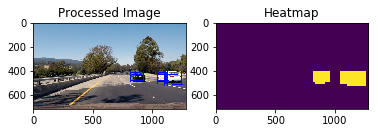

In [49]:
# test on one frame
global Detected_Cars
global heatmap
# initialize
heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
Detected_Cars = []

img1_x =process_img(image)
plt.subplot(121)
plt.imshow(img1_x)
plt.title('Processed Image')
plt.subplot(122)
plt.imshow(heatmap)
plt.title('Heatmap')

In [50]:
#process on a video
global Detected_Cars
global heatmap

# incialize 
heatmap = np.zeros_like(image[:,:,0]).astype(np.float) 
Detected_Cars = []

video_output = 'output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
lane_clip = clip1.fl_image(process_img)
%time lane_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [25:47<00:01,  1.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 25min 38s, sys: 2.54 s, total: 25min 40s
Wall time: 25min 48s


In [51]:
# show video stream
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))